In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
import pandas as pd
from scipy import signal

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [24]:
### ASTEP data import ###
data = pd.read_csv("betapic_astep_2017.csv")
data = data.drop(data[(data["FLAG"]==0) & (data["SUNELEV"] > -13)].index)

<IPython.core.display.Javascript object>


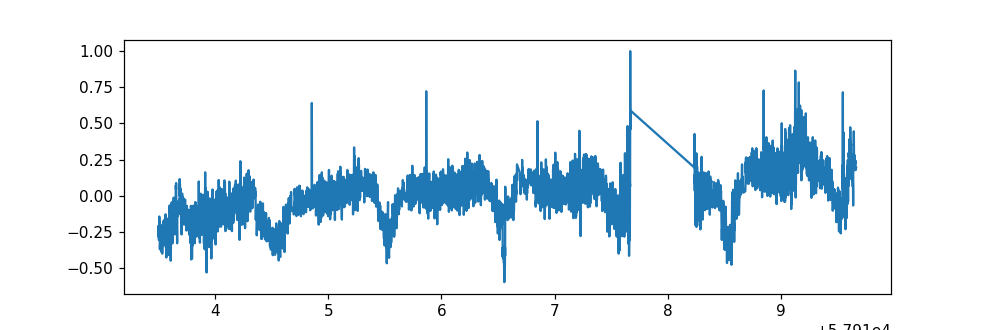

In [25]:
index = data["BJD"].loc[(data["BJD"] > 57913.5) & (data["BJD"] < 57920)].index
time = data["BJD"].loc[index].values
flux = data["FCAL1"].values
flux = flux[index]
flux = (flux-np.mean(flux))/(np.max(flux)-np.mean(flux))
plt.figure(figsize=(9,3))
#plt.scatter(time,flux,s=1)
#plt.plot(data["BJD"].values,data["FCAL1"].values)
plt.plot(time,flux)
plt.show()

In [5]:
# class CustomTerm(terms.Term):
#     parameter_names = ("log_a", "log_b", "log_c", "log_P")

#     def get_real_coefficients(self, params):
#         log_a, log_b, log_c, log_P = params
#         b = np.exp(log_b)
#         return (
#             np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(log_c),
#         )

#     def get_complex_coefficients(self, params):
#         log_a, log_b, log_c, log_P = params
#         b = np.exp(log_b)
#         return (
#             np.exp(log_a) / (2.0 + b), 0.0,
#             np.exp(log_c), 2*np.pi*np.exp(-log_P),
#         )

In [6]:
### GP Model ###
# log_a = 0.0;log_b = 0.0; log_c = 0.0; log_P = -3
# bounds = dict(log_a =(None,None),log_b =(None,None),log_c =(None,None),log_P =(-5,0))
# kernel = CustomTerm(log_a, log_b, log_c, log_P,bounds=bounds)
#bounds = dict(log_S0= (-20,10), log_Q = (-20,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=7., log_Q=2., log_omega0=5.)

gp = celerite.GP(kernel,mean=0.0)
gp.compute(time,yerr=(0.001-np.mean(flux))/(np.max(flux)-np.mean(flux)))

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -22341.637036276476
parameter_dict:
OrderedDict([('kernel:log_S0', 7.0), ('kernel:log_Q', 2.0), ('kernel:log_omega0', 5.0)])



In [7]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


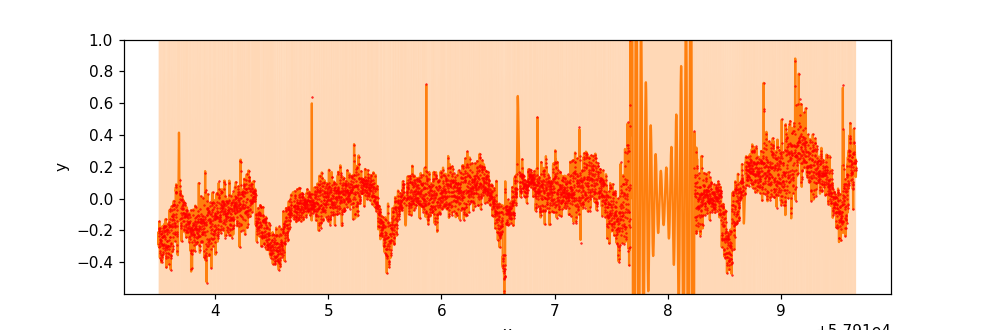

In [8]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [9]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -1078.7522904606567
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   394.38746171, 343820.69443382, -40675.01431564])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 256
      nit: 4
   status: 0
  success: True
        x: array([6.43383592, 1.98210308, 2.71425922])
Final log-likelihood: 1078.7522904606567
[622.55745238   7.25799106  15.09342508]
Parameters: OrderedDict([('kernel:log_S0', 6.4338359170620665), ('kernel:log_Q', 1.9821030777251085), ('kernel:log_omega0', 2.714259233528419)])


In [10]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)
P = 2*np.pi/np.exp(results.x[2])*60*24
P

599.4521983654035

<IPython.core.display.Javascript object>


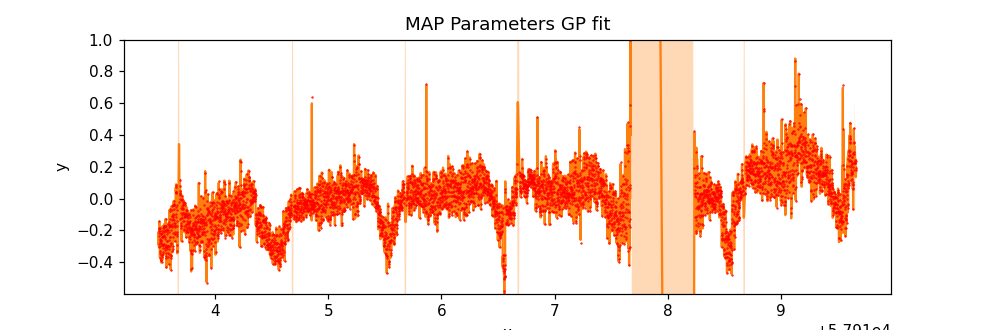

In [11]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [12]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [13]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 10)) :
        return 0
    return -np.inf

In [14]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [15]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

  0%|          | 0/500 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 12%|█▏        | 61/500 [00:00<00:00, 609.97it/s]

Running burn-in...


  1%|          | 35/5000 [00:00<00:18, 265.14it/s]

Running production...


100%|██████████| 5000/5000 [00:08<00:00, 589.52it/s]

Finished


In [16]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', 6.4338359170620665), ('kernel:log_Q', 1.9821030777251085), ('kernel:log_omega0', 2.714259223528419)])
Final MCMC log likelihood: 1078.7522904606567


<IPython.core.display.Javascript object>


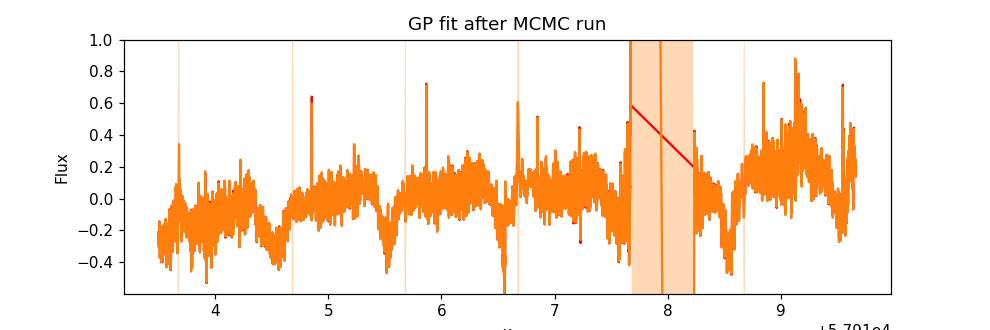

In [17]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(time,flux,c="r")
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

In [18]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[622.55745238   7.25799106  15.09342508]


2.402193208944127

In [19]:
P = 1/f
P*24*60

599.4521983654035

In [20]:
# x = np.linspace(1472,1480,10000)
# time = data[:,0][(1472<data[:,0])&(data[:,0]<1480)]
# flux = data[:,1][(1472<data[:,0])&(data[:,0]<1480)]
# flux = (flux - np.mean(flux))/(np.max(flux) - np.mean(flux))
# gp.compute(time,yerr=0.1*flux)
# pred_mean, pred_var = gp.predict(flux, x, return_var=True)
# pred_std = np.sqrt(pred_var)

In [21]:
# color = "#ff7f0e"
# plt.figure(figsize=(9,3))
# plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
# plt.plot(x, pred_mean, color=color)
# plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
# plt.xlabel("x")
# plt.ylabel("y")
# plt.ylim(np.min(flux),np.max(flux))
# plt.title("MAP Parameters GP fit")
# plt.show()

<IPython.core.display.Javascript object>


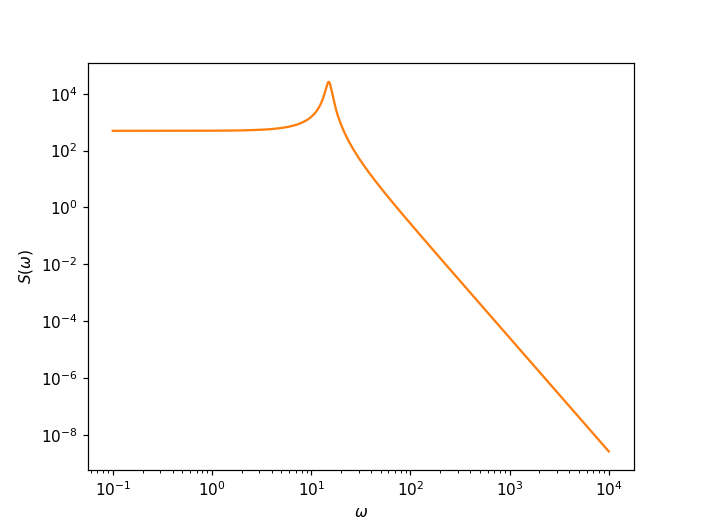

In [22]:
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


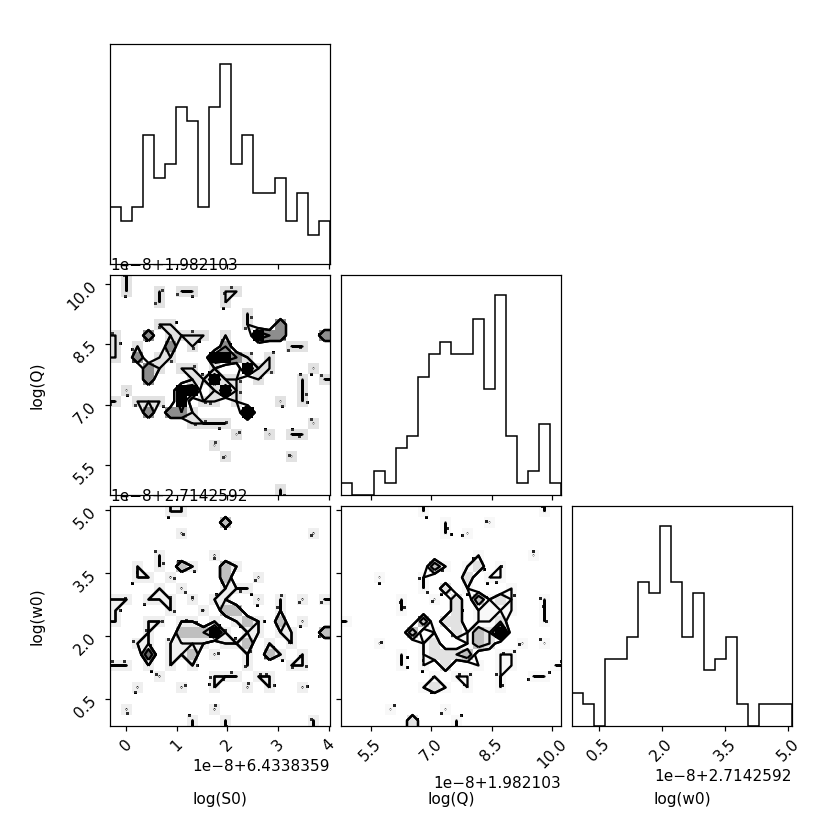

In [23]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*47.43)])
plt.show()

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

C:\ProgramData\Anaconda3\lib\site-packages\emcee\autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


[nan nan nan]


<IPython.core.display.Javascript object>


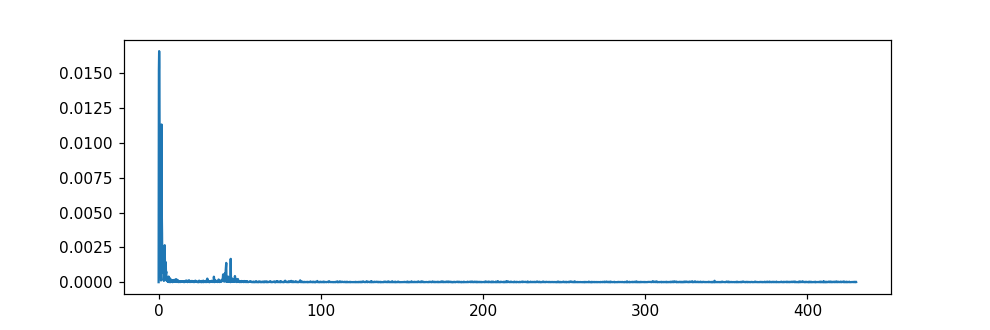

freq: 0.32440948795271635 d-1
periode 4438.834415995516 min


In [25]:
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(flux,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)

print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")